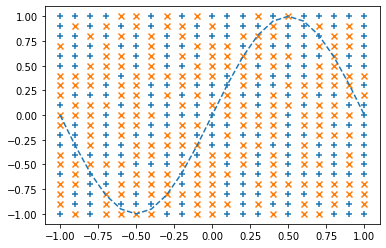

Epoch:0/100 Error:0.7189309684393662


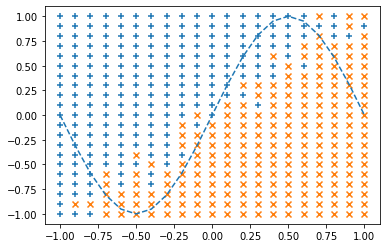

Epoch:10/100 Error:0.3924850938960169


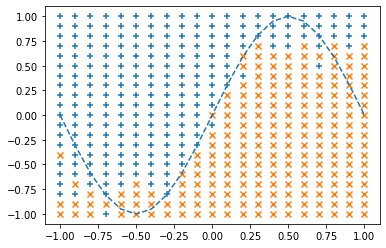

Epoch:20/100 Error:0.2500746157113762


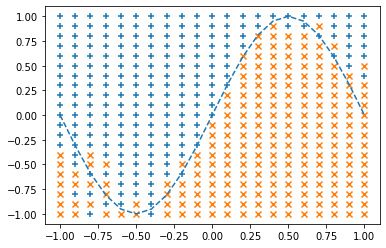

Epoch:30/100 Error:0.18368631571144317


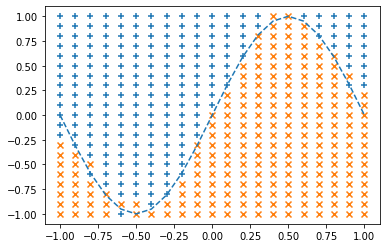

Epoch:40/100 Error:0.13855504622269618


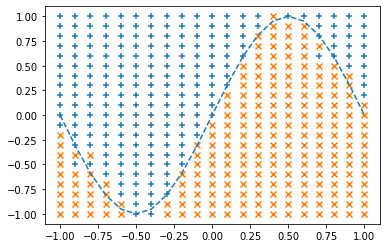

Epoch:50/100 Error:0.10459258199015826


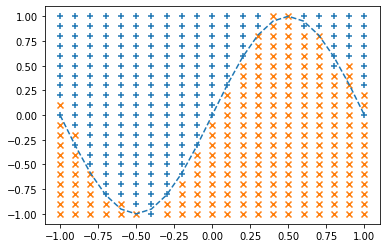

Epoch:60/100 Error:0.0859502560018348


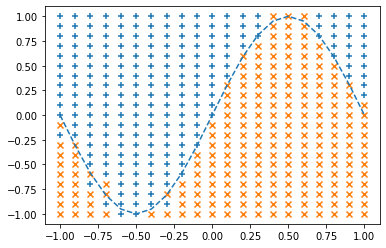

Epoch:70/100 Error:0.08222839346409654


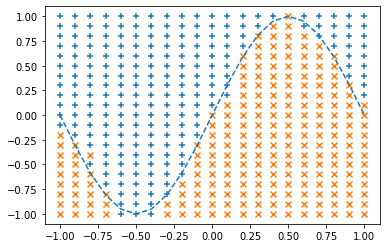

Epoch:80/100 Error:0.07493038900846222


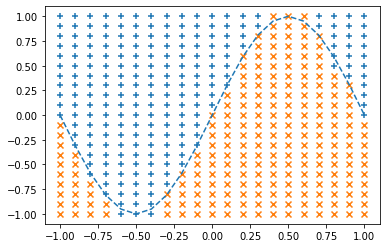

Epoch:90/100 Error:0.06959136927404684


In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# -- 座標 --
X = np.arange(-1.0, 1.1, 0.1)
Y = np.arange(-1.0, 1.1, 0.1)

# -- 入力、正解データを作成 --
input_data = []
correct_data = []
for x in X:
    for y in Y:
        input_data.append([x, y])
        if y < np.sin(np.pi * x):  # y座標がsinカーブよりも下であれば
            correct_data.append([0, 1])  # 下の領域
        else:
            correct_data.append([1, 0])  # 上の領域
            
n_data = len(correct_data)  # データ数

input_data = np.array(input_data)
correct_data = np.array(correct_data)

n_in = 2  # 入力層のニューロン数
n_mid = 6  # 中間層のニューロン数
n_out = 2  # 出力層のニューロン数

wb_width = 0.01  # 重みとバイアスの広がり具合
eta = 0.1  # 学習係数
epoch = 100  # 学習する回数
interval = 10  # 経過の表示間隔

# -- 中間層 --
class MiddleLayer:
    # コンストラクタ(初期化) 
    def __init__(self, n_upper, n):  # 初期設定
        # 重み(行列)とバイアス(ベクトル)
        self.w = wb_width * np.random.randn(n_upper, n)  # 重みの初期値の行列を作る(2 * 6)
        self.b = wb_width * np.random.randn(n)  # バイアスの初期値の行列を作る

    def forward(self, x):  # 順伝播
        self.x = x
        # 入力と重みの行列積＋バイアスの計算
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))  # シグモイド関数
    
    def backward(self, grad_y):  # 逆伝播
        # デルタの導出
        delta = grad_y * (1-self.y)*self.y  # シグモイド関数の微分
        
        # 重み、バイアス、入力の勾配を代入
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) # 転置
        
    def update(self, eta):  # 重みとバイアスの更新
        # self.w = self.w - eta * self.grad_w
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b

# -- 出力層 --
class OutputLayer:
    def __init__(self, n_upper, n):  # 初期設定
        self.w = wb_width * np.random.randn(n_upper, n)  # 重み(サイズ:6 * 2)
        self.b = wb_width * np.random.randn(n)  # バイアス(サイズ:2)
    
    def forward(self, x):  # 順伝播
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)  # ソフトマックス関数
    
    def backward(self, t):  # 逆伝播
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        
        self.grad_x = np.dot(delta, self.w.T) 

    def update(self, eta):  # 重みとバイアスの更新
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 各層の初期化 --
# n_in = 2, n_mid = 6
middle_layer = MiddleLayer(n_in, n_mid)
# n_mid = 6, n_out = 2
output_layer = OutputLayer(n_mid, n_out)

# -- 学習 --
sin_data = np.sin(np.pi * X) # 結果の検証用
for i in range(epoch):

    # インデックスをシャッフル
    index_random = np.arange(n_data)
    np.random.shuffle(index_random)
    
    # 結果の表示用
    total_error = 0
    x_1 = []
    y_1 = []
    x_2 = []
    y_2 = []
       
    for idx in index_random:
        
        x = input_data[idx]  # 入力
        t = correct_data[idx]  # 正解

        # 順伝播
        middle_layer.forward(x.reshape(1,2))  # 入力を行列に変換
        output_layer.forward(middle_layer.y)

        # 逆伝播
        output_layer.backward(t.reshape(1,2))  # 正解を行列に変換
        middle_layer.backward(output_layer.grad_x)
        
        # 重みとバイアスの更新
        middle_layer.update(eta)
        output_layer.update(eta)
        
        if i%interval == 0:
            
            y = output_layer.y.reshape(-1)  # 行列をベクトルに戻す

            # 交差エントロピー誤差
            total_error += - np.sum(t * np.log(y + 1e-7)) 
            
            # 確率の大小を比較し、分類する
            if y[0] > y[1]:
                x_1.append(x[0])
                y_1.append(x[1])
            else:
                x_2.append(x[0])
                y_2.append(x[1])
            
    if i%interval == 0:
        
        # 出力のグラフ表示
        plt.plot(X, sin_data, linestyle="dashed")
        plt.scatter(x_1, y_1, marker="+")
        plt.scatter(x_2, y_2, marker="x")
        plt.show()
        
        # エポック数と誤差の表示
        print("Epoch:" + str(i) + "/" + str(epoch), "Error:" + str(total_error/n_data))